# Custom P Controller with Limiter - Simulation and Real-Time Demo

This notebook demonstrates the `CustomPWithLimiter` sequence in two modes:
1. **Simulation Mode**: Inputs from CDL source blocks, outputs saved and plotted
2. **Real-Time Mode**: Pre-generated inputs fed one second at a time (mimicking BACnet controller)

## Controller Description
- **Control Law**: `y = min(yMax, k*e)`
- **Inputs**:
  - `e`: Control error (from Sin source)
  - `yMax`: Maximum output limit (from Constant source)
- **Parameters**:
  - `k`: Controller gain (set to 2.0)
- **Output**: `y`: Control signal

In [5]:
# Setup: Ensure cdl_python can be imported
import sys
import os

# Add parent directory to path to find cdl_python if not installed
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Try importing to verify it works
try:
    import cdl_python
    print("✓ cdl_python module found")
except ImportError:
    print("✗ cdl_python not found!")
    print("\nPlease install the package:")
    print("  cd /Users/akprakash/Programming/modelica/CDLPython")
    print("  pip install -e .")
    raise

✓ cdl_python module found


In [6]:
# Import required libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time as time_module
from datetime import datetime

# Import CDL blocks
from cdl_python.time_manager import TimeManager, ExecutionMode
from cdl_python.CDL.Reals.Sources import Constant, Sin

# Import the CustomPWithLimiter sequence
from custom_p_with_limiter import CustomPWithLimiter

print("✓ Imports successful")

✓ Imports successful


## Part 1: Simulation Mode

In simulation mode, we:
1. Create a TimeManager in SIMULATION mode
2. Create source blocks (Constant for yMax, Sin for e)
3. Create the controller
4. Step through time, computing outputs at each timestep
5. Save and plot the results

In [7]:
# Simulation parameters
time_step = 0.1  # 100ms timestep
duration = 10.0  # 10 seconds of simulation
num_steps = int(duration / time_step)

# Create TimeManager for simulation
tm_sim = TimeManager(mode=ExecutionMode.SIMULATION, time_step=time_step)

# Create source blocks
# yMax: constant at 5.0
ymax_source = Constant(time_manager=tm_sim, k=5.0)

# e: sine wave with amplitude=3, frequency=0.2 Hz (5 second period)
e_source = Sin(
    time_manager=tm_sim,
    amplitude=3.0,
    freqHz=0.2,
    phase=0.0,
    offset=0.0,
    startTime=0.0
)

# Create controller with gain k=2.0
controller = CustomPWithLimiter(k=2.0)

print(f"Simulation setup:")
print(f"  Duration: {duration} seconds")
print(f"  Time step: {time_step} seconds")
print(f"  Number of steps: {num_steps}")
print(f"  yMax: {ymax_source.k}")
print(f"  e source: Sin(amplitude={e_source.amplitude}, freq={e_source.freqHz} Hz)")
print(f"  Controller gain k: {controller.k}")

Simulation setup:
  Duration: 10.0 seconds
  Time step: 0.1 seconds
  Number of steps: 100
  yMax: 5.0
  e source: Sin(amplitude=3.0, freq=0.2 Hz)
  Controller gain k: 2.0


In [8]:
# Run simulation
sim_results = []

for step in range(num_steps + 1):
    current_time = tm_sim.get_time()
    
    # Get inputs from source blocks
    ymax_val = ymax_source.compute()['y']
    e_val = e_source.compute()['y']
    
    # Compute controller output
    result = controller.compute(e=e_val, yMax=ymax_val)
    y_val = result['y']
    
    # Store results
    sim_results.append({
        'time': current_time,
        'e': e_val,
        'yMax': ymax_val,
        'y': y_val,
        'k_times_e': controller.k * e_val  # What output would be without limiter
    })
    
    # Advance time
    if step < num_steps:
        tm_sim.advance(dt=time_step)

# Convert to DataFrame
df_sim = pd.DataFrame(sim_results)

print(f"\n✓ Simulation complete: {len(df_sim)} samples collected")
print(f"\nFirst few samples:")
print(df_sim.head(10))


✓ Simulation complete: 101 samples collected

First few samples:
   time         e  yMax         y  k_times_e
0   0.0  0.000000   5.0  0.000000   0.000000
1   0.1  0.376000   5.0  0.751999   0.751999
2   0.2  0.746070   5.0  1.492139   1.492139
3   0.3  1.104374   5.0  2.208747   2.208747
4   0.4  1.445261   5.0  2.890522   2.890522
5   0.5  1.763356   5.0  3.526712   3.526712
6   0.6  2.053641   5.0  4.107283   4.107283
7   0.7  2.311540   5.0  4.623079   4.623079
8   0.8  2.532984   5.0  5.000000   5.065968
9   0.9  2.714481   5.0  5.000000   5.428962


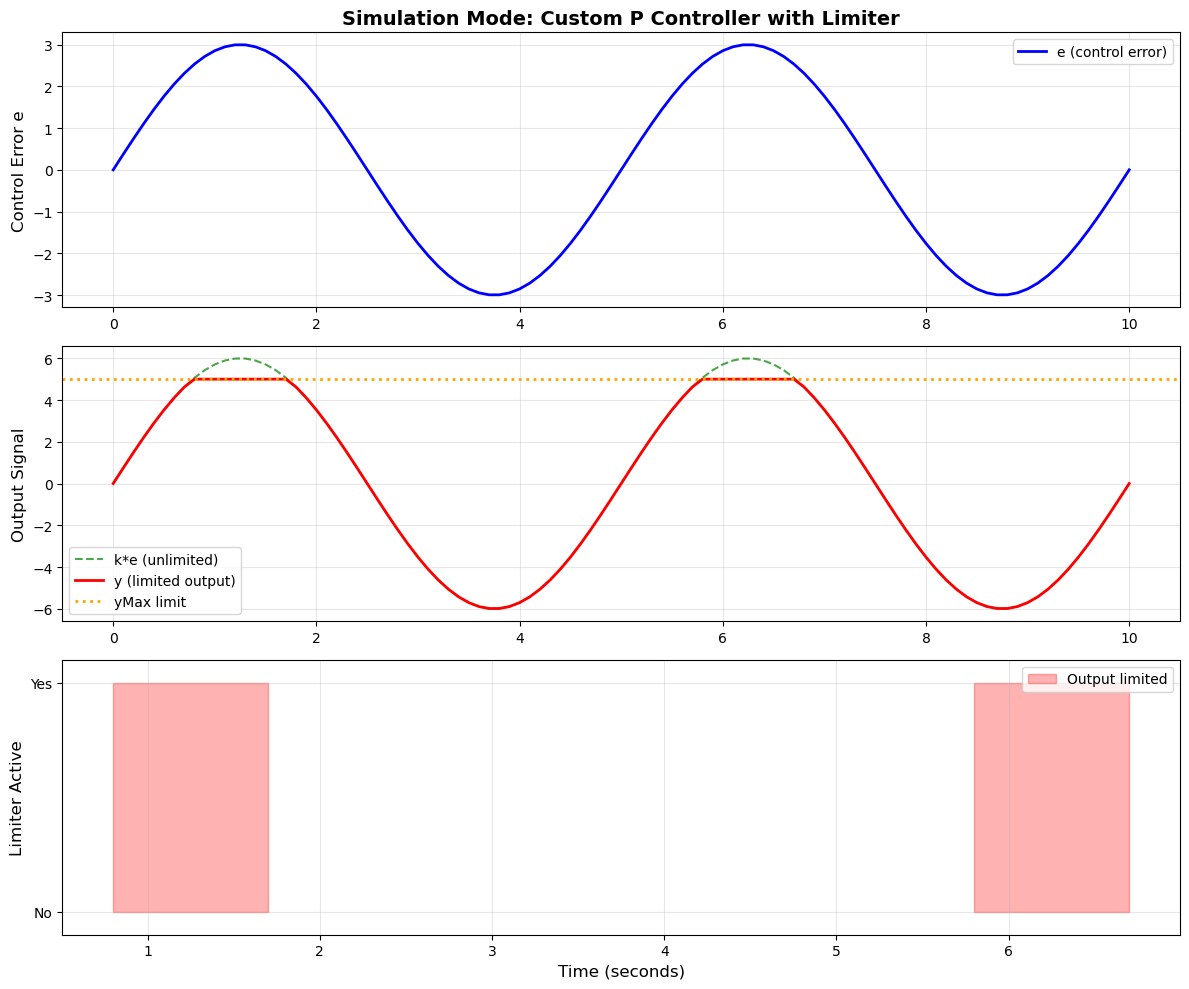


✓ Simulation plots saved to 'simulation_mode_results.png'


In [9]:
# Plot simulation results
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Plot 1: Input signal e (error)
axes[0].plot(df_sim['time'], df_sim['e'], 'b-', linewidth=2, label='e (control error)')
axes[0].set_ylabel('Control Error e', fontsize=12)
axes[0].set_title('Simulation Mode: Custom P Controller with Limiter', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# Plot 2: Output y and limiting behavior
axes[1].plot(df_sim['time'], df_sim['k_times_e'], 'g--', linewidth=1.5, label='k*e (unlimited)', alpha=0.7)
axes[1].plot(df_sim['time'], df_sim['y'], 'r-', linewidth=2, label='y (limited output)')
axes[1].axhline(y=df_sim['yMax'].iloc[0], color='orange', linestyle=':', linewidth=2, label='yMax limit')
axes[1].set_ylabel('Output Signal', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)

# Plot 3: Limiting indicator (shows when output is being limited)
is_limited = df_sim['y'] < df_sim['k_times_e']
axes[2].fill_between(df_sim['time'], 0, 1, where=is_limited, alpha=0.3, color='red', label='Output limited')
axes[2].set_ylabel('Limiter Active', fontsize=12)
axes[2].set_xlabel('Time (seconds)', fontsize=12)
axes[2].set_ylim([-0.1, 1.1])
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(['No', 'Yes'])
axes[2].grid(True, alpha=0.3)
axes[2].legend(fontsize=10)

plt.tight_layout()
plt.savefig('simulation_mode_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Simulation plots saved to 'simulation_mode_results.png'")

## Part 2: Real-Time Mode

In real-time mode, we:
1. Pre-generate source data (simulating BACnet points)
2. Feed data one second at a time to the controller
3. Record outputs with timestamps
4. Plot the results

This mimics a real controller that receives sensor inputs from BACnet every second.

In [10]:
# Real-time parameters
rt_duration = 20.0  # 20 seconds
rt_time_step = 1.0  # 1 second updates (like BACnet polling)
rt_num_steps = int(rt_duration / rt_time_step)

print(f"Real-time setup:")
print(f"  Duration: {rt_duration} seconds")
print(f"  Update interval: {rt_time_step} second (mimicking BACnet polling)")
print(f"  Number of updates: {rt_num_steps}")
print(f"\nGenerating source data...")

# Step 1: Pre-generate source data (simulating BACnet sensor readings)
# Create a separate TimeManager for data generation
tm_datagen = TimeManager(mode=ExecutionMode.SIMULATION, time_step=rt_time_step)

ymax_gen = Constant(time_manager=tm_datagen, k=5.0)
e_gen = Sin(
    time_manager=tm_datagen,
    amplitude=4.0,
    freqHz=0.1,  # 10 second period
    phase=0.0,
    offset=0.0,
    startTime=0.0
)

# Generate the data
source_data = []
for step in range(rt_num_steps + 1):
    t = tm_datagen.get_time()
    ymax = ymax_gen.compute()['y']
    e = e_gen.compute()['y']
    
    source_data.append({
        'time': t,
        'yMax': ymax,
        'e': e
    })
    
    if step < rt_num_steps:
        tm_datagen.advance(dt=rt_time_step)

# Convert to DataFrame (this is our "BACnet data")
df_source = pd.DataFrame(source_data)

print(f"✓ Generated {len(df_source)} source data points")
print(f"\nSource data preview:")
print(df_source.head())

Real-time setup:
  Duration: 20.0 seconds
  Update interval: 1.0 second (mimicking BACnet polling)
  Number of updates: 20

Generating source data...
✓ Generated 21 source data points

Source data preview:
   time  yMax         e
0   0.0   5.0  0.000000
1   1.0   5.0  2.351141
2   2.0   5.0  3.804226
3   3.0   5.0  3.804226
4   4.0   5.0  2.351141


In [11]:
# Step 2: Feed data one second at a time to controller (real-time mode)
print(f"\nStarting real-time execution...")
print(f"Feeding data at 1-second intervals (like BACnet)\n")

# Create controller for real-time mode
controller_rt = CustomPWithLimiter(k=2.0)

# Results storage
rt_results = []

# Process each data point with timestamp
for idx, row in df_source.iterrows():
    # Record wall-clock timestamp
    wall_clock_time = datetime.now()
    
    # Get inputs from "BACnet"
    e_val = row['e']
    ymax_val = row['yMax']
    
    # Compute controller output
    result = controller_rt.compute(e=e_val, yMax=ymax_val)
    y_val = result['y']
    
    # Store results with timestamps
    rt_results.append({
        'sim_time': row['time'],
        'wall_clock': wall_clock_time,
        'e': e_val,
        'yMax': ymax_val,
        'y': y_val,
        'k_times_e': controller_rt.k * e_val
    })
    
    # Print progress every 5 seconds
    if idx % 5 == 0:
        print(f"t={row['time']:5.1f}s: e={e_val:6.3f}, yMax={ymax_val:5.2f}, y={y_val:6.3f}")
    
    # Sleep for 1 second to simulate real-time (optional - can comment out for faster demo)
    # time_module.sleep(1.0)

# Convert to DataFrame
df_rt = pd.DataFrame(rt_results)

print(f"\n✓ Real-time execution complete: {len(df_rt)} samples processed")


Starting real-time execution...
Feeding data at 1-second intervals (like BACnet)

t=  0.0s: e= 0.000, yMax= 5.00, y= 0.000
t=  5.0s: e= 0.000, yMax= 5.00, y= 0.000
t= 10.0s: e=-0.000, yMax= 5.00, y=-0.000
t= 15.0s: e= 0.000, yMax= 5.00, y= 0.000
t= 20.0s: e=-0.000, yMax= 5.00, y=-0.000

✓ Real-time execution complete: 21 samples processed


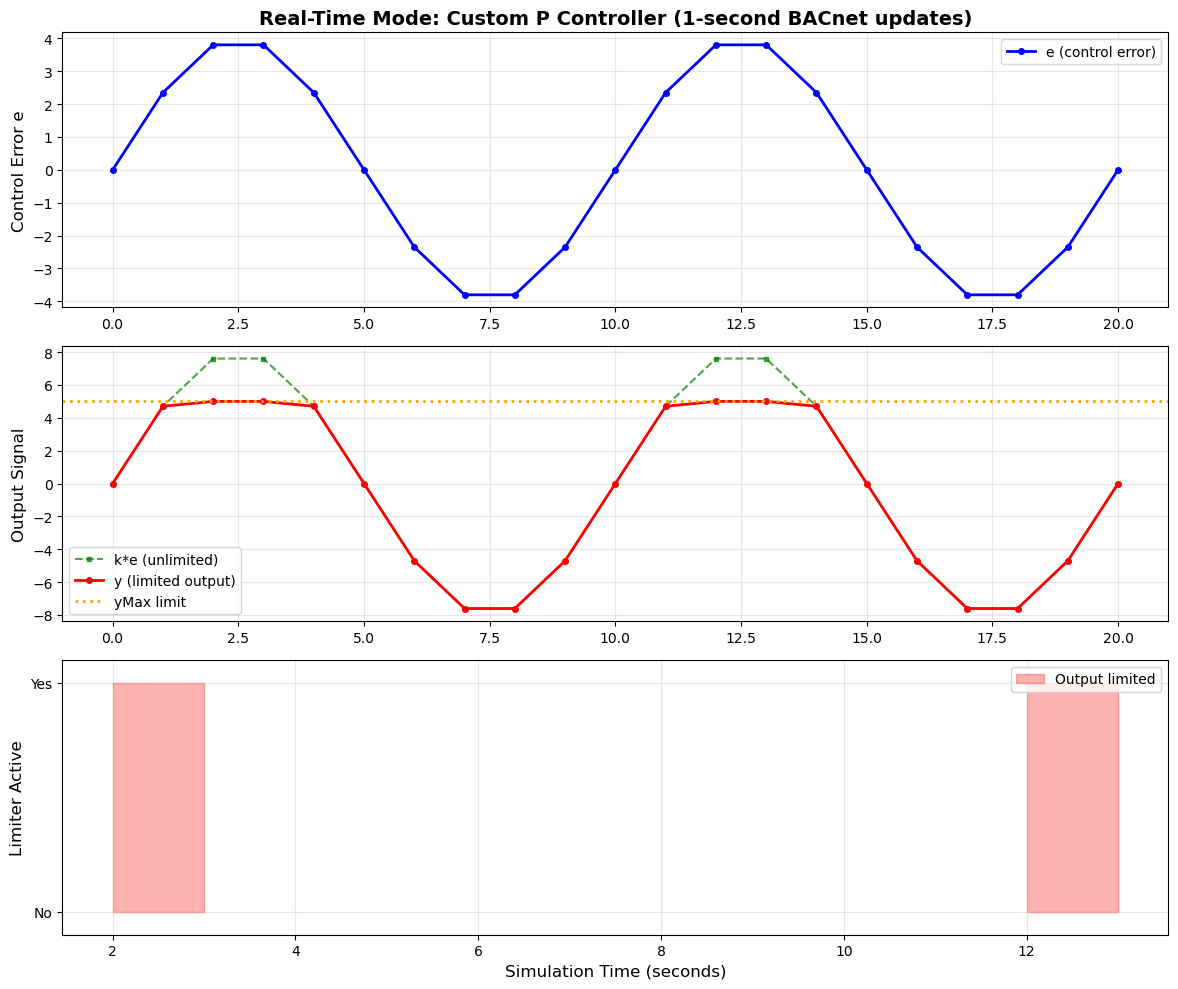


✓ Real-time plots saved to 'realtime_mode_results.png'


In [12]:
# Plot real-time results
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Plot 1: Input signal e
axes[0].plot(df_rt['sim_time'], df_rt['e'], 'b-', linewidth=2, marker='o', markersize=4, label='e (control error)')
axes[0].set_ylabel('Control Error e', fontsize=12)
axes[0].set_title('Real-Time Mode: Custom P Controller (1-second BACnet updates)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# Plot 2: Output y and limiting behavior  
axes[1].plot(df_rt['sim_time'], df_rt['k_times_e'], 'g--', linewidth=1.5, marker='s', markersize=3, label='k*e (unlimited)', alpha=0.7)
axes[1].plot(df_rt['sim_time'], df_rt['y'], 'r-', linewidth=2, marker='o', markersize=4, label='y (limited output)')
axes[1].axhline(y=df_rt['yMax'].iloc[0], color='orange', linestyle=':', linewidth=2, label='yMax limit')
axes[1].set_ylabel('Output Signal', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)

# Plot 3: Limiting indicator
is_limited_rt = df_rt['y'] < df_rt['k_times_e']
axes[2].fill_between(df_rt['sim_time'], 0, 1, where=is_limited_rt, alpha=0.3, color='red', step='post', label='Output limited')
axes[2].set_ylabel('Limiter Active', fontsize=12)
axes[2].set_xlabel('Simulation Time (seconds)', fontsize=12)
axes[2].set_ylim([-0.1, 1.1])
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(['No', 'Yes'])
axes[2].grid(True, alpha=0.3)
axes[2].legend(fontsize=10)

plt.tight_layout()
plt.savefig('realtime_mode_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Real-time plots saved to 'realtime_mode_results.png'")

## Summary

This notebook demonstrated the `CustomPWithLimiter` controller in two execution modes:

### Simulation Mode
- Used CDL source blocks (Constant, Sin) to generate inputs
- Stepped through time with TimeManager
- Fine timestep (0.1s) for smooth curves

### Real-Time Mode
- Pre-generated source data (simulating BACnet sensor readings)
- Fed data one second at a time to controller
- Recorded outputs with wall-clock timestamps
- Coarser timestep (1s) mimicking real BACnet polling

Both modes show:
- Controller amplifies error by gain k=2.0
- Output is clamped by yMax limiter when k*e exceeds limit
- Sine wave input creates periodic limiting behavior

In [13]:
# Show statistics
print("=" * 60)
print("SIMULATION MODE STATISTICS")
print("=" * 60)
print(f"Total samples: {len(df_sim)}")
print(f"Time step: {time_step}s")
print(f"\nOutput (y) statistics:")
print(df_sim['y'].describe())
print(f"\nPercentage of time limited: {(df_sim['y'] < df_sim['k_times_e']).sum() / len(df_sim) * 100:.1f}%")

print("\n" + "=" * 60)
print("REAL-TIME MODE STATISTICS")
print("=" * 60)
print(f"Total samples: {len(df_rt)}")
print(f"Time step: {rt_time_step}s")
print(f"\nOutput (y) statistics:")
print(df_rt['y'].describe())
print(f"\nPercentage of time limited: {(df_rt['y'] < df_rt['k_times_e']).sum() / len(df_rt) * 100:.1f}%")

SIMULATION MODE STATISTICS
Total samples: 101
Time step: 0.1s

Output (y) statistics:
count    1.010000e+02
mean    -1.221051e-01
std      4.080831e+00
min     -5.988160e+00
25%     -4.107283e+00
50%     -7.258818e-15
75%      4.107283e+00
max      5.000000e+00
Name: y, dtype: float64

Percentage of time limited: 19.8%

REAL-TIME MODE STATISTICS
Total samples: 21
Time step: 1.0s

Output (y) statistics:
count    21.000000
mean     -0.496848
std       5.016283
min      -7.608452
25%      -4.702282
50%       0.000000
75%       4.702282
max       5.000000
Name: y, dtype: float64

Percentage of time limited: 19.0%
